In [10]:
import pandas as pd
import pandas_ta as ta
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.extensions.autoreload import append_obj
from networkx import fast_gnp_random_graph
from sklearn.preprocessing import StandardScaler
from datetime import date, datetime
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Downloading historical data for Apple Inc. (AAPL), and Google LLC (GOOGL),  Microsoft Corp. (MSFT) to files
Technological industry is strongly related, so we need information about Apple and Google price to be able to predict MSFT price movement better
    

In [11]:
#Downloading historical data for Apple Inc. (AAPL), Microsoft Corp. (MSFT), and Google LLC (GOOGL) to files

tickers = ['AAPL', 'GOOGL', 'MSFT']

for share in tickers:
    share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
    
    if isinstance(share_data.columns, pd.MultiIndex):
        share_data.columns = share_data.columns.get_level_values(0)
        
    share_data.reset_index(inplace=True)    
    share_data.rename(columns={'Date':'DATE'}, inplace=True)
    share_data.to_csv(f'prices/historical_{share}_data.csv', index=False)
    print('*' * 18, {share}, '*' * 18)
    print(share_data.head(3))
    print('*' * 40)

/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_12168/567743609.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed
/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_12168/567743609.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

****************** {'AAPL'} ******************
Price       DATE     Close      High       Low      Open     Volume
0     2000-01-03  0.839281  0.843498  0.762428  0.786328  535796800
1     2000-01-04  0.768521  0.829440  0.758680  0.811633  512377600
2     2000-01-05  0.779767  0.828971  0.772270  0.777892  778321600
****************************************
****************** {'GOOGL'} ******************
Price       DATE     Close      High       Low      Open     Volume
0     2004-08-19  2.492181  2.584576  2.383393  2.483736  893181924
1     2004-08-20  2.690134  2.709259  2.496155  2.508822  456686856
2     2004-08-23  2.717207  2.818544  2.708514  2.750738  365122512
****************************************



/var/folders/rs/rx9snnk15ss4_d166y1sz82h0000gn/T/ipykernel_12168/567743609.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  share_data = yf.download(share, start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed


****************** {'MSFT'} ******************
Price       DATE      Close       High        Low       Open    Volume
0     2000-01-03  35.601452  36.231397  34.207937  35.849612  53228400
1     2000-01-04  34.398823  35.773249  34.284287  34.685161  54119000
2     2000-01-05  34.761532  35.544191  33.406195  33.940694  64059600
****************************************


### Calculate RSI, MACD, ATR, Bolliner Bands 
They tell us about:
- **RSI:** It calculates the speed and changes of price movement  
        If RSI > 70 => stock is bought out  
        If RSI < 30 => stock is sold out  
        
- **MACD:** It shows us the relation between two moving averages of price  
        -> **MACD_12_26_9** is the main indicator line 
             - (val >0) suggests increasing trend  
             - (val <0) suggest decreasing trend   
        -> **MACDs_12_26_9** is a signal line, it's the moving averege of MACD_12_26_9     
              - It doesn't tell us much, but it's relation with MACD_12_26_9 is the most important  
        -> **MACDh_12_26_9** is a histogram of the difference between MACD line and it's signal line  
            - (val > 0): the growth momentum is accelerating
            - (val < 0): downward momentum dominates
            
- **ATR:** It measures stock market variability  
    the higher value of ATR the more stock price was variable last 14 days
  
- **Bolliger Bands:** It defines the range in which the price usually moves  
    -> ** BBM_20_2.0 - Middle band:  
        It's a 20-day simple moving average (SMA) of the closing price.
    -> **BBU_20_2.0** - Upper band: it's the BBM + 2σ  
        It acts as dynamic resistance. Statistically, the price rarely stays above this line  
    -> **BBL_20_2.0** - Lower band: it's the BBM - 2σ  
        It acts like dynamic support  
    -> **BBB_20_2.0** - Band width: 
        It's a percent diversity between upper and lower bands:  
        - High BBB means that market is very volatile and stock's price movements are very nervous at the moment  
    -> **BBP_20_2.0** - %B indicator
    If:
        - value = 1.0: The price is exactly on Upper band   
        - value = 0.5: The price is exactly on Middle band  
        - value = 0.0: The price is exactly on Lower band  
        - value > 1.0: The price has broken the Upper band  
        - value < 0.0:  The price has broken the Lower band

In [12]:
for share in tickers:
    stock_data = pd.read_csv(f'prices/historical_{share}_data.csv')
    
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = stock_data.columns.get_level_values(0)
        
    ### RSI
    stock_data.ta.rsi(length=14, append=True)
    
    
    ### MACD
    stock_data.ta.macd(fast=12, slow=26, signal=9, append=True)
    
    ### ATR 
    stock_data.ta.atr(length=14, append=True)
    
    ### Bollinger Bands
    stock_data.ta.bbands(length=20,std=2, append=True)
    
    stock_data['Target'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)
    
    stock_data.dropna(inplace=True)
    
    stock_data.reset_index(inplace=True)
    stock_data.rename(columns={'Date':'DATE'}, inplace=True)
    print('*' * 18, {share}, '*' * 18)
    print(stock_data.head())
    print('*' * 40)
    
    stock_data.to_csv(f'stock market data/ {share}_data.csv', index=False)


****************** {'AAPL'} ******************
   index        DATE     Close      High       Low      Open     Volume  \
0     33  2000-02-18  0.834127  0.865054  0.831314  0.859432  233441600   
1     34  2000-02-22  0.853339  0.876770  0.799917  0.825691  422296000   
2     35  2000-02-23  0.871614  0.892234  0.832251  0.849004  473099200   
3     36  2000-02-24  0.863765  0.893171  0.837875  0.879581  376432000   
4     37  2000-02-25  0.827565  0.877238  0.825691  0.860837  249144000   

      RSI_14  MACD_12_26_9  MACDh_12_26_9  MACDs_12_26_9   ATRr_14  \
0  41.602296      0.026497      -0.000356       0.026853  0.047914   
1  44.206909      0.025563      -0.001032       0.026595  0.049981   
2  46.644701      0.025998      -0.000478       0.026475  0.050696   
3  45.720710      0.025416      -0.000848       0.026263  0.051024   
4  41.625351      0.021782      -0.003585       0.025367  0.051062   

   BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
0        0.7

## Loading Macroeconomic data : 


### - FEDFUNDS - Fed Funds Rate (pol: Stopy procentowe):  
    - High interest rates typically hurt technology companies because they reduce the value of future earnings and increase borrowing costs


        DATE  FEDFUNDS
0 2000-01-01      5.45
1 2000-02-01      5.73
2 2000-03-01      5.85
3 2000-04-01      6.02
4 2000-05-01      6.27


Text(0.5, 1.0, 'Fed Funds Rate')

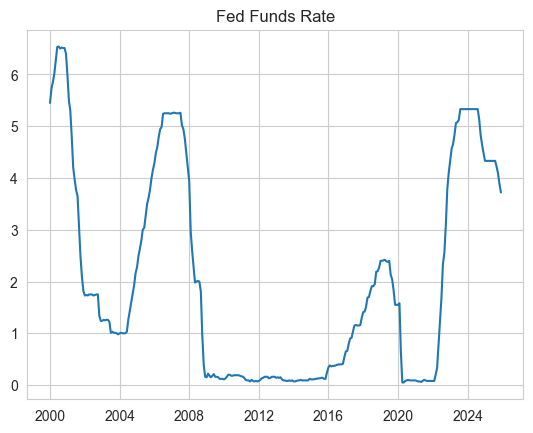

In [13]:
## Loading macro economic data
### need to install pandas-datareader 

### Fed Funds Rate (pol: Stopy procentowe)

FEDFUNDS = web.DataReader('FEDFUNDS', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
FEDFUNDS.reset_index(inplace=True)

print(FEDFUNDS.head())
FEDFUNDS.to_csv('Macroeconomic data/ FEDFUNDS.csv', index=False)

plt.plot(FEDFUNDS['DATE'], FEDFUNDS['FEDFUNDS'])
plt.title('Fed Funds Rate')
                               

### - DGS10 -  Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (pol: Rentowność Obligacji 10-letnich):  
    -The increase in bond yields often causes capital to flow out of stocks into safer bonds.


        DATE  DGS10
0 2000-01-03   6.58
1 2000-01-04   6.49
2 2000-01-05   6.62
3 2000-01-06   6.57
4 2000-01-07   6.52


Text(0.5, 1.0, 'DGS10')

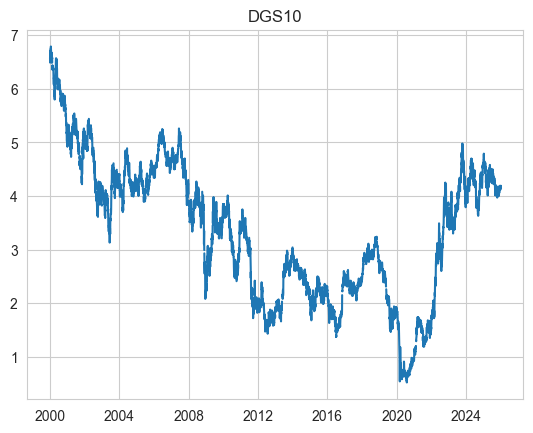

In [14]:
### Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (pol: Rentowność Obligacji 10-letnich)

DGS10 = web.DataReader('DGS10', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
DGS10.reset_index(inplace=True)
print(DGS10.head())
DGS10.to_csv('Macroeconomic data/ DGS10.csv', index=False)
plt.plot(DGS10['DATE'], DGS10['DGS10'])
plt.title('DGS10')

### - CPI - Inflation Indicator (pol: Wskaźnik Inflacji)
    - High inflation could force the Fed to raise interest rates, which would indirectly hurt stock's valuation. On the other hand, stock with a strong market position can pass on costs to customers (pricing power).

        DATE    CPI
0 2000-01-01  169.3
1 2000-02-01  170.0
2 2000-03-01  171.0
3 2000-04-01  170.9
4 2000-05-01  171.2
5 2000-06-01  172.2
6 2000-07-01  172.7
7 2000-08-01  172.7
8 2000-09-01  173.6
9 2000-10-01  173.9


Text(0.5, 1.0, 'CPI')

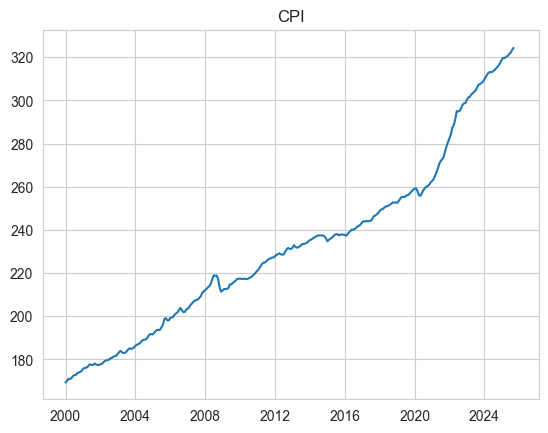

In [15]:
### CPI (pol: Wskaznik inflacji)

CPI = web.DataReader("CPIAUCSL", 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
CPI.reset_index(inplace=True)
CPI.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
print(CPI.head(10))
CPI.to_csv('Macroeconomic data/ CPI.csv', index=False)
plt.plot(CPI['DATE'], CPI['CPI'])
plt.title('CPI')

### - Dollar index (pol: Indeks dollara):  
    -A strong dollar (high index) means that foreign profits are lower when converted into dollars, which negatively affects the company's financial results.


        DATE  Dollar_idx
0 2006-01-02    101.4155
1 2006-01-03    100.7558
2 2006-01-04    100.2288
3 2006-01-05    100.2992
4 2006-01-06    100.0241
5 2006-01-09    100.1794
6 2006-01-10    100.1436
7 2006-01-11     99.8710
8 2006-01-12    100.0643
9 2006-01-13     99.9675


Text(0.5, 1.0, 'Dollar Index')

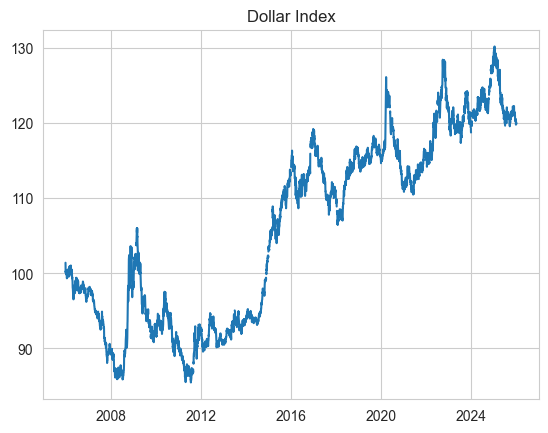

In [16]:
### Dollar index 

Dollar_idx = web.DataReader('DTWEXBGS', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
Dollar_idx.reset_index(inplace=True)
Dollar_idx.rename(columns={'DTWEXBGS': 'Dollar_idx'}, inplace=True)
print(Dollar_idx.head(10))
Dollar_idx.to_csv('Macroeconomic data/ Dollar_idx.csv', index=False)
plt.plot(Dollar_idx['DATE'], Dollar_idx['Dollar_idx'])
plt.title('Dollar Index')


Text(0.5, 1.0, 'All Macroeconomic datasets plots')

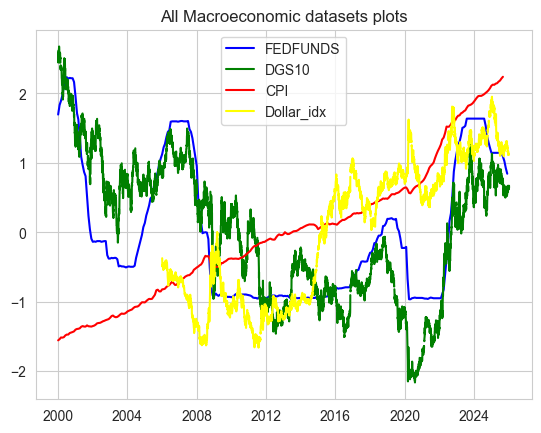

In [17]:
### Setting the same data time for all data

macroeconomic_datasets = [FEDFUNDS, DGS10, CPI, Dollar_idx]
labels = ['FEDFUNDS', 'DGS10', 'CPI', 'Dollar_idx']
plot_colors = ['blue', 'green', 'red', 'yellow', 'black']
scaler = StandardScaler()

for idx, dataset in enumerate(macroeconomic_datasets):
    dataset.sort_values('DATE', inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    dataset[labels[idx] + "_scaled"] = scaler.fit_transform(dataset[[labels[idx]]])
    plt.plot(dataset['DATE'], dataset[labels[idx] + '_scaled'], color=plot_colors[idx])
    dataset.drop(labels[idx] + '_scaled', inplace=True, axis=1)
plt.legend(labels)
plt.title('All Macroeconomic datasets plots')



### VIX - FEAR INDEX:

   VIX < 20-> Relative calm on the stock market  
   VIX 20 - 30 -> Increased volatility, uncertainty  
   VIX > 30 -> Panic on the stock market   

In [18]:
## FEAR INDEX

start_date = datetime(year=2000, month=1, day=1)
end_date = date.today().strftime('%Y-%m-%d')
fear_idx = yf.download(tickers= '^VIX',
                   start=start_date,
                   end=end_date,
                   auto_adjust=True,
                   progress=False,
                   interval="1d")
fear_idx.columns = [col[0] for col in fear_idx.columns]
fear_idx = pd.DataFrame(fear_idx)
fear_idx['VIX_percent'] = fear_idx['Close'].pct_change()
fear_idx.dropna(inplace=True)
fear_idx['Is_Panic'] = (fear_idx['Close'] > 30).astype(int)
fear_idx['Is_Calm'] = (fear_idx['Close'] < 20).astype(int)
fear_idx['Is_Uncertain'] = ((fear_idx['Close'] >= 20) & (fear_idx['Close'] <= 30)).astype(int)

fear_idx.reset_index(inplace=True)
fear_idx.rename(columns={'Date':'DATE'}, inplace=True)
fear_idx.to_csv('fear and sentiment data/ fear_idx.csv', index=False)
fear_idx.head()

,DATE,Close,High,Low,Open,Volume,VIX_percent,Is_Panic,Is_Calm,Is_Uncertain
0,2000-01-04,27.010000,27.180000,24.799999,24.940001,0,0.115655,0,0,1
1,2000-01-05,26.410000,29.000000,25.850000,27.980000,0,-0.022214,0,0,1
2,2000-01-06,25.730000,26.709999,24.700001,26.680000,0,-0.025748,0,0,1
3,2000-01-07,21.719999,25.170000,21.719999,25.139999,0,-0.155849,0,0,1
4,2000-01-10,21.709999,22.490000,21.360001,21.889999,0,-0.000460,0,0,1


### FINANCIAL NEWS SENTIMENT
-    It measures uncertainty of the economic policy  
      High uncertainty causes investors to avoid risk, which may hinder price growth in technology stocks.

In [19]:
### FINANCIAL NEWS

financial_sentiment = web.DataReader('USEPUINDXD', 'fred', start='2000-01-01', end=date.today().strftime('%Y-%m-%d'))
financial_sentiment.reset_index(inplace=True)
print(financial_sentiment.head())
financial_sentiment.to_csv('fear and sentiment data/ financial_sentiment.csv', index=False)

        DATE  USEPUINDXD
0 2000-01-01       68.04
1 2000-01-02      119.36
2 2000-01-03       35.73
3 2000-01-04      109.31
4 2000-01-05      123.22


In [31]:
GOOGL = pd.read_csv('stock market data/ GOOGL_data.csv')
AAPL = pd.read_csv('stock market data/ AAPL_data.csv')
MSFT = pd.read_csv('stock market data/ MSFT_data.csv')

columns = AAPL.columns
columns = columns[2:]

for c in columns:
    GOOGL.rename(columns={c: c+'_GOOGL'}, inplace=True)
    AAPL.rename(columns={c: c+'_AAPL'}, inplace=True)
    MSFT.rename(columns={c: c+'_MSFT'}, inplace=True)

In [40]:
### MERGE ALL DATASETS TOGETHER

stock_dfs = {
    'MSFT': MSFT,
    'AAPL': AAPL,
    'GOOGL': GOOGL
}
for share in stock_dfs.keys():
    main_share = stock_dfs[share]
    datasets = [FEDFUNDS, DGS10, CPI, Dollar_idx, financial_sentiment, fear_idx]
    data = main_share.copy()
    data['DATE'] = pd.to_datetime(data['DATE'])
    for other_share in stock_dfs.keys():
        if other_share != share:
            other_data = pd.read_csv(f'prices/historical_{other_share}_data.csv')
            datasets.append(other_data)
    
    for dataset in datasets:
        dataset['DATE'] = pd.to_datetime(dataset['DATE'])
        data = pd.merge(data, dataset, on='DATE', how='left')
    
    features = [col for col in data.columns if col not in ['Target', 'DATE']]
    data[features] = data[features].shift(1) #model needs to see data from yesterday
    print('*' * 18, share, '*' * 18 )
    print(data.head(3))
    print('*' * 40)
    
    stock_dfs[share] = data

****************** MSFT ******************
   index       DATE  Close_MSFT  High_MSFT   Low_MSFT  Open_MSFT  Volume_MSFT  \
0    NaN 2000-02-18         NaN        NaN        NaN        NaN          NaN   
1   33.0 2000-02-22   29.034744  30.561884  28.977477  30.542795   79063000.0   
2   34.0 2000-02-23   28.652958  29.664688  28.347530  29.053832   66296200.0   

   RSI_14_MSFT  MACD_12_26_9_MSFT  MACDh_12_26_9_MSFT  ...   Close_y  \
0          NaN                NaN                 NaN  ...       NaN   
1    31.629519          -0.866585           -0.218361  ...  0.834127   
2    30.545643          -0.966703           -0.254783  ...  0.853339   

     High_y     Low_y    Open_y     Volume_y  Close  High  Low  Open  Volume  
0       NaN       NaN       NaN          NaN    NaN   NaN  NaN   NaN     NaN  
1  0.865054  0.831314  0.859432  233441600.0    NaN   NaN  NaN   NaN     NaN  
2  0.876770  0.799917  0.825691  422296000.0    NaN   NaN  NaN   NaN     NaN  

[3 rows x 42 columns]
****

In [43]:
### CLEANING DATA
for share in tickers:
    data = stock_dfs[share]
    data.ffill(inplace=True)
    columns = MSFT.columns[1:6]
    for c in columns:
        data.rename(columns={c+'_y': c+'_VIX'}, inplace=True)
    data.drop('Volume_x', inplace=True, axis=1)
        
    print(data.head())
    
    data.to_csv(f'all_{share}_data.csv', index=False)

   index       DATE  Close_AAPL  High_AAPL  Low_AAPL  Open_AAPL  Volume_AAPL  \
0    NaN 2000-02-18         NaN        NaN       NaN        NaN          NaN   
1   33.0 2000-02-22    0.834127   0.865054  0.831314   0.859432  233441600.0   
2   34.0 2000-02-23    0.853339   0.876770  0.799917   0.825691  422296000.0   
3   35.0 2000-02-24    0.871614   0.892234  0.832251   0.849004  473099200.0   
4   36.0 2000-02-25    0.863765   0.893171  0.837875   0.879581  376432000.0   

   RSI_14_AAPL  MACD_12_26_9_AAPL  MACDh_12_26_9_AAPL  ...  Is_Uncertain  \
0          NaN                NaN                 NaN  ...           NaN   
1    41.602296           0.026497           -0.000356  ...           1.0   
2    44.206909           0.025563           -0.001032  ...           1.0   
3    46.644701           0.025998           -0.000478  ...           1.0   
4    45.720710           0.025416           -0.000848  ...           1.0   

     Close_y     High_y      Low_y     Open_y    Volume_y  Clo

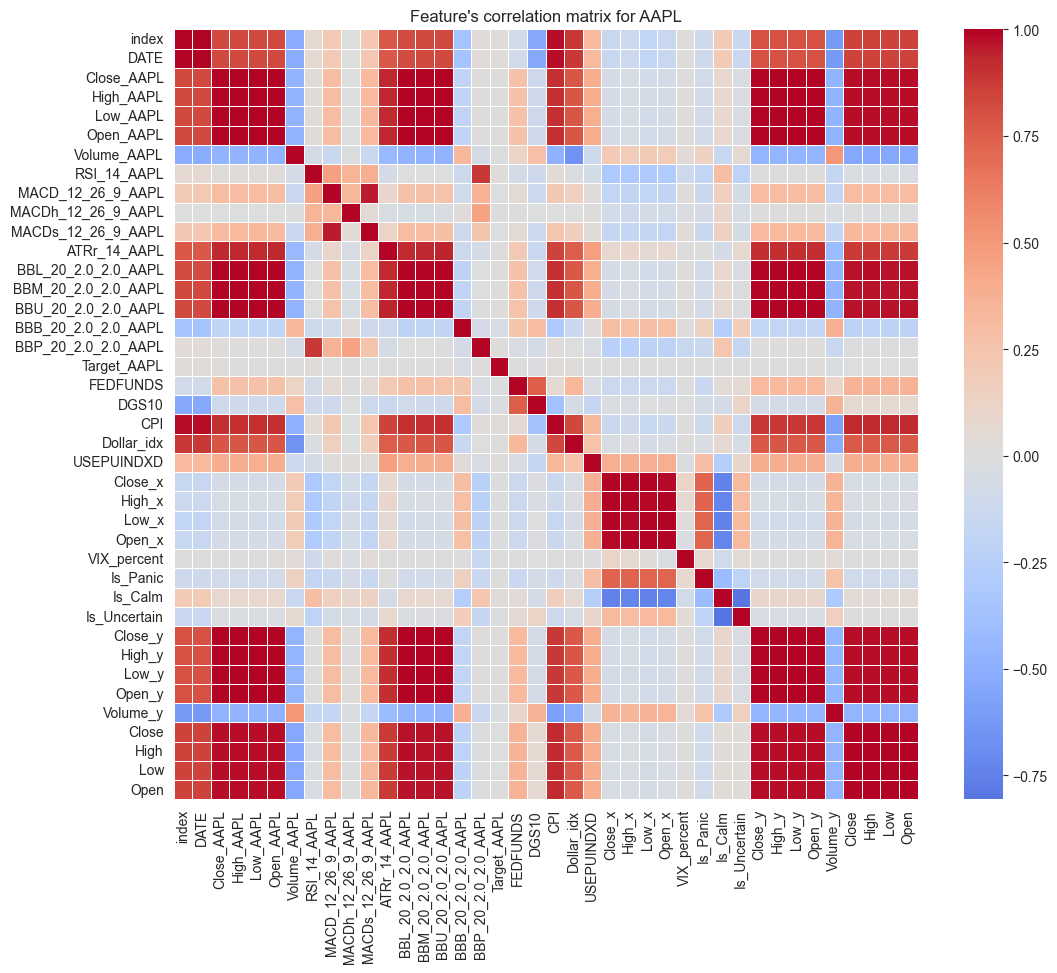

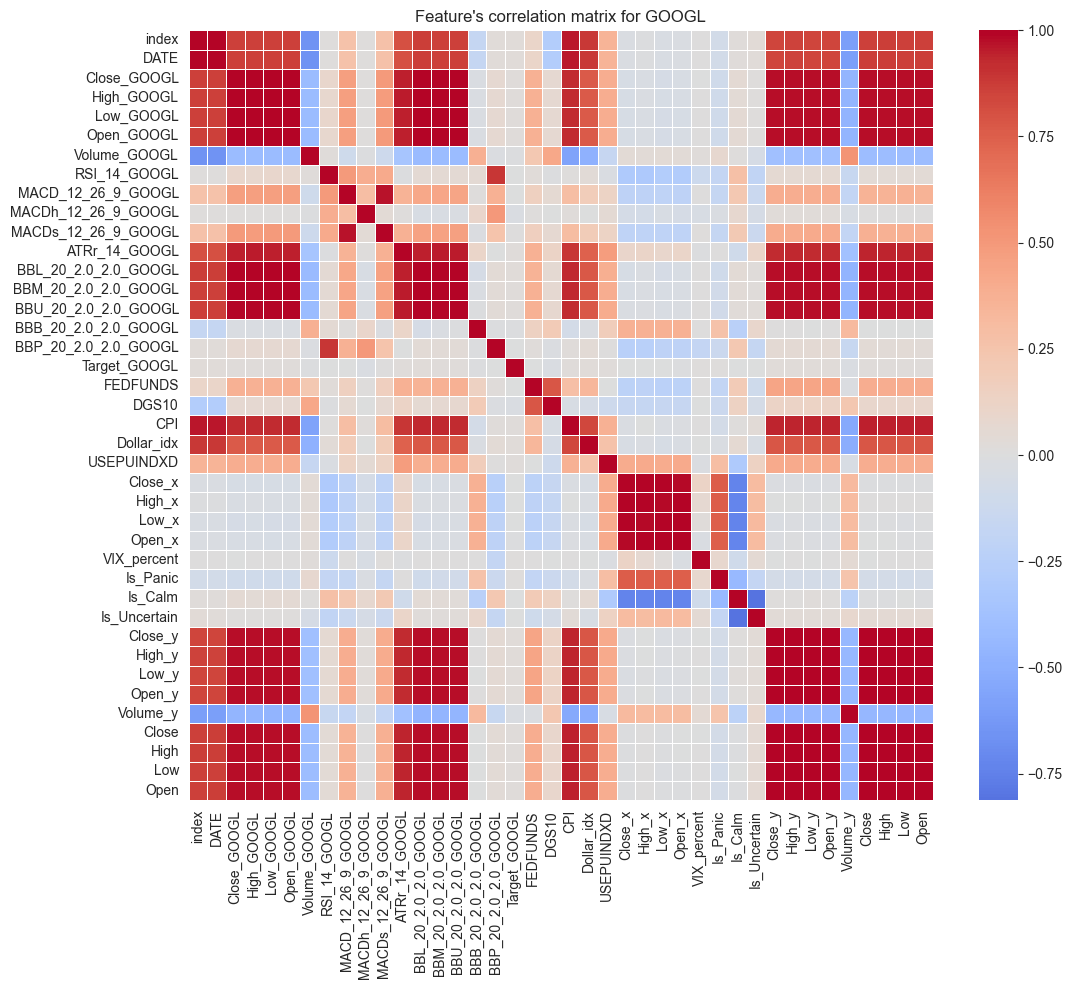

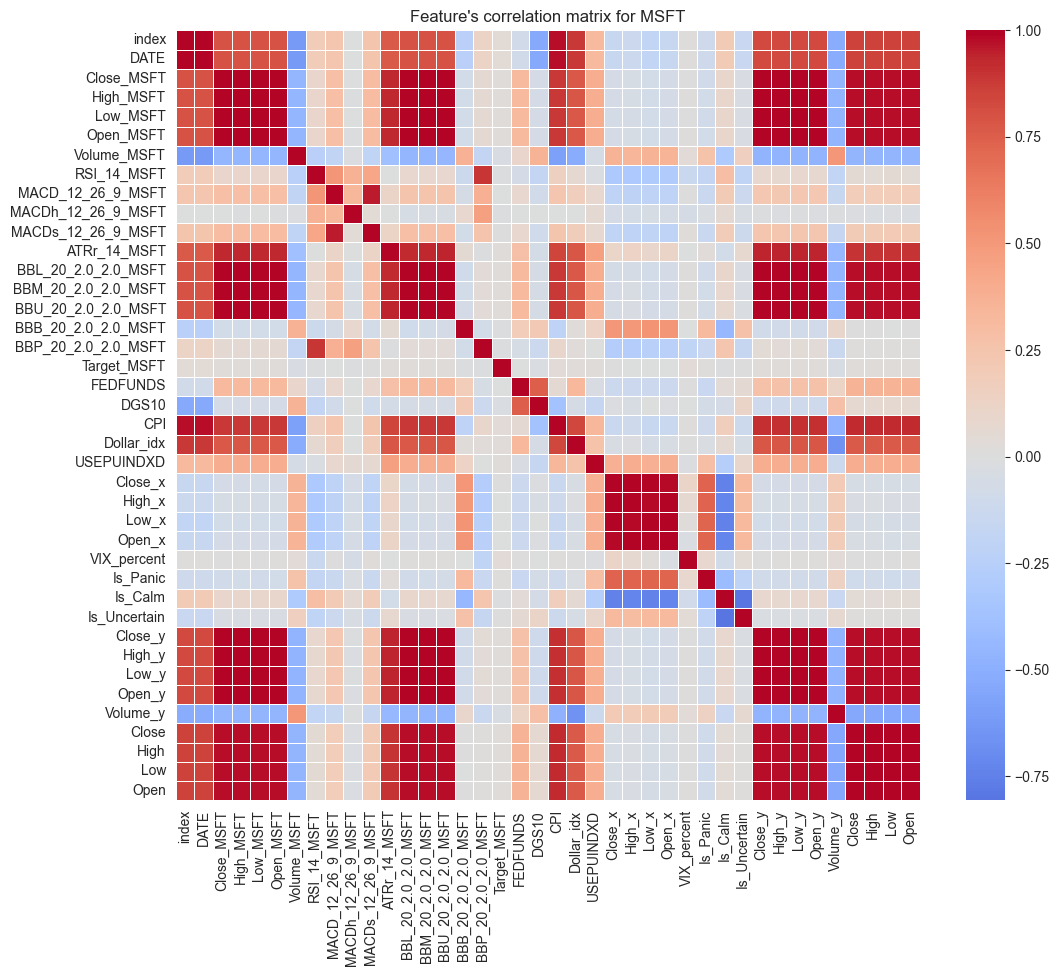

In [44]:
#### HEATMAP OF CORRELACTION  MATRIX
for share in tickers:
    data = stock_dfs[share]
    corr_matrix = data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, 
                annot=False,     
                cmap='coolwarm',    
                center=0, 
                linewidths=.5)
    
    plt.title(f"Feature's correlation matrix for {share}")
    plt.savefig(f'Feature_corr_matrix_for_{share}.png')
    plt.show()